<a href="https://colab.research.google.com/github/Kuuro-neko/M1_IMAGINE_ML_Project/blob/main/ML_Project_Group_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Projet Machine Learning</H1>
<H2>HAI817I - 2024/2025</H2>
<H3>Classification d'assertions venant d’X (Twitter) selon leur rapport à la science </H3>



<H1>Groupe 8 </H1>
<br>

Duban Mathis: 22102226

Gonzalez Oropeza Gilles : 21602817

Bernardon Vincent : 22009116

LONGLADE Mickaël : 22105047




<H2> Sujet </H2>

Ce projet s’inscrit dans le contexte de l’apprentissage supervisé, i.e. les données possèdent des
labels. Il vise à trouver les modèles les plus performants pour prédire si des assertions (une
assertion est une proposition que l'on avance et que l'on soutient comme vraie) faites par des
hommes politiques (par exemple) sont vraies ou fausses.




---



## **Installation**


Dans cette partie, nous allons installer toutes les librairies dont nous allons avoir besoin pour notre projet.




In [1]:
# Installation des librairies pour le projet
!pip install pandas numpy scipy gensim emoji nltk matplotlib seaborn scikit-learn inflect googletrans==4.0.0-rc1 contractions pyspellchecker optuna

import warnings # Supprime les warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies de manipulation de données (graphique, lecture de données,ect...)
import pandas as pd # Lecture de données
import numpy as np # Array
import seaborn as sns #
import matplotlib.pyplot as plt # Graphique
import sys

# Librairies pour la fonction prepareText
import re # Regular expression
import nltk
import json
from nltk.corpus import stopwords #English stopwords
nltk.download('stopwords') # Téléchargement des stopwords (une seule fois)
from nltk.corpus import wordnet #Mots pour vérifier les suppressions de lettres répétées
nltk.download('wordnet') # Téléchargement de mots existants
import emoji
import inflect # Transformation des chiffres en mots
import re
from googletrans import Translator # Traduction de langues
from nltk.stem import WordNetLemmatizer # Lemmatisation des mots
from nltk.stem import PorterStemmer # Racinanisation des mots
nltk.download('punkt') #Tagetisation des mots
nltk.download('punkt_tab') # Tokenisation des mots
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from nltk import pos_tag # Tagination des mots
from nltk.tokenize import word_tokenize
import unicodedata # Suppresion d'accent
import contractions # Transformation des contractions
from collections import Counter
from collections import defaultdict

#Libraries pour l'entraînement du modèle
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorisation
from sklearn.preprocessing import MaxAbsScaler, StandardScaler # Vectorisation
from spellchecker import SpellChecker # dictionnaire phonétique
from sklearn.feature_extraction.text import CountVectorizer # Topic modelling
from sklearn.decomposition import LatentDirichletAllocation #LDA
from sklearn import preprocessing # Upsampling
from imblearn.over_sampling import SMOTE # Upsampling
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler  # if resampleData doesn't balance
import sklearn
from sklearn.preprocessing import LabelEncoder #Label encoder

from gensim.models.coherencemodel import CoherenceModel #Coherence model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # matrices de confusion
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # couleur pour les graphiques
from sklearn.utils import resample # Upsampling
from wordcloud import WordCloud # Nuage de mot
from gensim.corpora.dictionary import Dictionary # évaluation de cohérenec
from gensim.models import LdaModel # LDA
import os

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
import optuna
from scipy import stats

# Classifiers
from sklearn.tree import DecisionTreeClassifier # Decision TREE classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Importation du répertoire de travail sur Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
path='/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project/'
sys.path.append(path)
%cd $path
%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project


'/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project'

Récupération des données du dataSet présent sur le répertoire Google Drive en ligne


In [3]:
# Importation des données
df=pd.read_csv('dataSet/data.csv', sep='\t')
# Lecture des 5 premières lignes pour confirmer la bonne récupération des données
display (df.head())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Récupération de nos dictionnaires :

In [4]:
# Récupération des monnaies
currency_file=pd.read_csv('dataSet/currency_translation.csv')
display (currency_file.head())
# Création d'un objet dictionnaire pour répertorier les monnaies
currency_dict = dict(zip(currency_file['Currency Symbol'], currency_file['Currency Name']))
# Récupération des abbréviations (Slang)
slang_file=pd.read_csv('dataSet/slang_translation.csv')
display (slang_file.head())
# Création d'un objet dictionnaire pour répertorier les abbréviations
slang_dict = dict(zip(slang_file['Abbreviation'], slang_file['Meaning']))

,Currency Symbol,Currency Name
0,$,dollar
1,€,euro
2,£,pound
3,¥,yen
4,₹,indian rupee


,Abbreviation,Meaning
0,4ao,for adults only
1,a.m,before midday
2,a3,anytime anywhere anyplace
3,aamof,as a matter of fact
4,acct,account


## **Ingénierie des données**

Dans cette partie, on s'interésse au pré-traitement des données. Afin que chaque élément de notre base soit utilisable et pertinent on va nettoyer, normaliser et transformer nos données afin qu'elles soient préparées et optimales pour nos analyses.


<br>

On va ici répertorier tous les éléments qui doivent être traités :

<br>


| Élément            | Exemple                 | Traitement à effectuer | Exemple après traitement |
|--------------------|------------------------|-------------------------|--------------------------|
| Emojis            | 🏀                     | Suppression des émojis ou remplacement par leur signification |  basketball |
| Mention Twitter   | @username               | Remplacement par un Token |  @MENTION |
| Hashtag           | #example                |  Remplacement par un Token | @HASHTAG |
| URL               | http://t.co/XGUfUDoLJB  | Suppression de l'URL | "" |
| Chiffre           | 13                      | Transformation en String | thirdteen |
| Majuscules        | Hello                    | Suppression de la majuscule | hello |
| Ponctuation       | !                        | Suppression de la ponctuation | "" |
| Mots répétés      | cool cool cool         | Normalisation en une seule occurrence | cool |
| Lettres répétées  | that's greeeeeeeat!        | Réduction des répétitions excessives | that's great! |
| Abréviations      | ngl, fr | Remplacement par la version complète | not gonna lie, for real |
| Stopwords (déterminants)         | the, and, a  | Suppression si non pertinent | "" |
| Slang (Argot)     | gonna, dunno, wanna           | Remplacement par des mots standards | going to, do not know, want to |
| Langue étrangère  | bonjour, gracias          | Détection et traduction éventuelle | hello, thank you |
| Caractères spéciaux | §, $, ^                | Suppression des caractères | "" |
| Expressions courantes | btw, lol    | Remplacement par la version complète | by the way, laughing out loud|
| Négation mal formatée | ain't, dunno          | Correction grammaticale | am not, do not know |
| Émojis en Unicode | `\U0001F60D` (😍)      | Conversion en texte lisible | smiling_face_with_hearteyes |
| Symboles de devises |    10\$, 10€               | Normalisation (ex: "10 euros") | 10 dollars, 10 euros |
| Accents |    cliché              | Normalisation (Suppression des accents) | cliche |
| Heures |    10AM, 13:30              | Remplacement par un token | @TIME  |
| Numéro de téléphone |  +339208373  | Remplacement par un token | @PHONENUMBER  |
| Expression flottante |  14,34 10,000  | Conversion en texte lisible | fourteen thirty-four,  ten thousand |







On implémente ici nos fonctions que nous allons utiliser par la suite pour notre ingéniérie des données :

In [5]:
#Fonction permettant de gérer les caractères spéciaux ayant un sens particulier (n° de tel commençant par +, format horaire, nombres...)
def removeSpecialCharacters(word, keepTokens):
    # Replace '+' followed by digits (potential phone numbers) with 'PHONE_NUMBER'
    if keepTokens:
        word = re.sub(r'\+\d+', 'TOKENPHONENUMBER', word)
    else:
        word = re.sub(r'\+\d+', '', word)

    # Remove / between numbers : 10/10 -> 10 out of 10
    word = re.sub(r'(\d+)/(\d+)', r'\1 out of \2', word)

    # Replace time expressions in HH:MM format
    if keepTokens:
        word = re.sub(r'\b\d{1,2}:\d{2}\b', 'TOKENTIME', word)
    else:
        word = re.sub(r'\b\d{1,2}:\d{2}\b', '', word)

    # Replace numbers followed by 'k' with their full value (e.g., 41916514k → 41916514000 ,  or 5.5k -> 5500)
    word = re.sub(r'(\d+)k\b', lambda m: str(int(m.group(1)) * 1000), word)
    return word

#Fonction permet de supprimer les répétitions successives de lettres (cas particuliers rencontrés)
def fixRepeat(word):
    # Reduce excessive repetition to exactly 2 occurrences
    repeat_regexp = re.compile(r'(\w*)(\w)\2{2,}(\w*)')
    repl = r'\1\2\2\3'

    if wordnet.synsets(word):
        return word

    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:
        return fixRepeat(repl_word)

    # Try all combinations of removing one duplicate letter at a time
    candidates = set()
    for i in range(len(repl_word) - 1):
        if repl_word[i] == repl_word[i + 1]:
            candidates.add(repl_word[:i] + repl_word[i+1:])

    # Check if any of the candidates is a valid word
    for candidate in candidates:
        if wordnet.synsets(candidate):
            return candidate

    # No valid word is found, return the single-letter version
    single_letter_version = re.sub(r'(.)\1', r'\1', repl_word)
    return single_letter_version

# Fonction permettant de supprimer les accents
def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

On créer donc notre fonction **prepareText** permettant de préparer nos données brutes afin de les reformater correctement :

In [6]:
stop_words_set = set(stopwords.words('english'))
translator = Translator() # initialisation du traducteur
lemmatizer = WordNetLemmatizer() # initialisation du lematiseur
stemmer = PorterStemmer() # initialisation du "racinisateur"
tokens = {"MENTION", "HASHTAG", "TIME", "PHONENUMBER"} # liste de nos token à identifier

# Fonction permettant de préparer la chaîne de charactères passée en paramètre
def prepareText(text, keepTokens: bool = True, keepEmojis: bool = True, numbersAsTokens: bool = False, translate = True):
    """
    Prépare la chaîne de caractère passée en paramètre

    Parameters
    ----------
    text : str
        La chaîne de caractères
    keepTokens : bool, optional
        True si on doit garder les token, False si on doit les supprimer (defaut : True)
    keepEmojis : bool, optional
        True si on doit garder les emojis, False si on doit les supprimer (defaut : True)
    numbersAsTokens : bool, optional
        True si on doit transformer les chiffres en token, False si on doit les supprimer (defaut : False)
         Ce token n'est pas supprimé si keepToken vaut False
    translate : bool, optional
        True si on doit traduire le texte en anglais, False si on ne le fait pas (defaut : True)

    Returns
    -------
    str
        La chaîne de caractère préparée
    """
    #Majuscule, suppression
    data = str(text).lower()

    #Suppression d'accent
    data = remove_accents(data)

    #Contraction, on corrige
    data = contractions.fix(data)

    #Emoji, transformation en String
    if (keepEmojis):
        data = emoji.demojize(data)
    else:
        data = emoji.replace_emoji(data, replace='')

    #Mention Twitter, transformation en Token
    if (keepTokens):
        data = re.sub(r'@\w+', 'TOKENMENTION', data)
    else:
        data = re.sub(r'@\w+', '', data)

    #Hashtag, transformation en Token
    if (keepTokens):
        data = re.sub(r'#\w+', 'TOKENHASHTAG', data)
    else:
        data = re.sub(r'#\w+', '', data)

    #URL, on supprime
    data = re.sub(r'https?://\S+|www\.\S+', '', data)


    #Devise, remplacement par sa chaîne de caractères
    for symbol, name in currency_dict.items():
        data = re.sub(rf'(\d+){re.escape(symbol)}', r'\1 ' + name, data)


    #Special caracters that requires more attention than just remove
    data = removeSpecialCharacters(data, keepTokens)

    #Keep rating expressions (ex : 10/10)
    rating_expressions = {}

    def replace_match(match):
        key = f"RATING_{len(rating_expressions)}"  # Unique placeholder
        rating_expressions[key] = match.group(0)   # Store full match
        return key

    # Replace rating expressions with placeholders
    data = re.sub(r'(\d+|ten|nine|eight|seven|six|five|four|three|two|one) out of (\d+|ten|nine|eight|seven|six|five|four|three|two|one)', replace_match, data)


    #Stopwords, suppression
    data = ' '.join([word for word in data.split() if word not in stop_words_set])

    # Restore full rating expressions
    for key, value in rating_expressions.items():
        data = data.replace(key, value)

    #Ponctuation & charactères spéciaux, suppression
    data = re.sub(r'[^\w\s]', '', data)

    #Chiffre, transformation en String
    if (numbersAsTokens):
        words = data.split()
        data = ' '.join(["number" if word.isdigit() else word for word in words])
    else:
        words = data.split()
        data = ' '.join([inflect.engine().number_to_words(word) if word.isdigit() else word for word in words])

    #Heures, transformation en token
    if keepTokens:
        data = re.sub(r'\b(\d{1,2}([:h]\d{2})?\s*(am|pm)?)\b', 'TOKENTIME', data)
    else:
        data = re.sub(r'\b(\d{1,2}([:h]\d{2})?\s*(am|pm)?)\b', '', data)

    #Abréviation (Slang)
    data = ' '.join([slang_dict.get(word, word) for word in data.split()])

    #Mots répétés
    data = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', data)
    #Lettres répétés
    data = ' '.join([fixRepeat(word) for word in data.split()])

    #remplacer TOKEN par @TOKENxxxx correspondant
    if (keepTokens):
        for token in tokens:
            data = re.sub(rf'TOKEN{token}', f'{token}', data)

    #Traduction du tweet
    if translate:
        try:
            data = translator.translate(data, dest='en').text
        except Exception as e:
            pass

    return data

Exemple du passage de notre fonction


In [7]:
#URL
display("http://t.co/XGUfUDoLJB")
display(prepareText("http://t.co/XGUfUDoLJB"))
print("\n")
#Chiffre
display("3")
display(prepareText("3"))
print("\n")
#Majuscule
display("Hello")
display(prepareText("Hello"))
print("\n")
#Ponctuation
display("Hello!")
display(prepareText("Hello!"))
print("\n")
#Abréviation
display("lol")
display(prepareText("lol"))
print("\n")
#StepWord
display("After planning the project, she carefully researched each step, ensuring the execution was smooth and timely")
display(prepareText("After planning the project, she carefully researched each step, ensuring the execution was smooth and timely"))
print("\n")
#Emojis
display("😍")
display("keepEmojis=True : " + prepareText("😍", keepEmojis=True))
display("keepEmojis=False : " + prepareText("😍", keepEmojis=False))
print("\n")
#Traductions (dernière étape)
display("我今天去超市买了一些水果")
display("translate=True : " + prepareText("我今天去超市买了一些水果", translate=True))
display("translate=False : " + prepareText("我今天去超市买了一些水果", translate=False))
print("\n")
#Mention Twitter
display("as @username said it's bad !")
display("keepTokens=True : " + prepareText("as @username said it's bad !", keepTokens=True))
display("keepTokens=False : " + prepareText("as @username said it's bad !", keepTokens=False))
print("\n")
#Hashtag
display("I went to the theater to see Dune 2 #Dune")
display(prepareText("I went to the theater to see Dune 2 #Dune"))
print("\n")
#Charactères spéciaux
display("§$£")
display(prepareText("§$£"))
print("\n")
#Devices
display("10$ 10£ 10€")
display(prepareText("10$ 10£ 10€"))
print("\n")
#Mot répétés
display("Cool Cool Cool Cool Hot Hot Hot")
display(prepareText("Cool Cool Cool Cool Hot Hot Hot"))
print("\n")
#Lettres répétées
display("Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive")
display(prepareText("Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive"))
print("\n")
#Accent
display("cliché")
display(prepareText("cliché"))
print("\n")
#Heures
display("10AM computer 10:30 potatoes 10h30")
display(prepareText("10AM computer 10:30 potatoes 10h30"))
print("\n")
#Numéro de téléphone
display("+33123456789")
display(prepareText("+33123456789"))
print("\n")
#Expression flottante
display("14,34 10,000")
display("numbersAsTokens=True : " + prepareText("14,34 10,000", numbersAsTokens=True))
display("numbersAsTokens=True : " + prepareText("14,34 10,000", numbersAsTokens=False))
print("\n")
# 10/10
display("10/10")
display(prepareText("10/10"))
print("\n")
#Charactères spéciaux (numéro de téléphone, x/x , 10,0000)
display("N. Lutz ")
display(prepareText("N. Lutz"))
print("\n")

'http://t.co/XGUfUDoLJB'

''

'3'

'three'

'Hello'

'hello'

'Hello!'

'hello'

'lol'

'laughing out loud'

'After planning the project, she carefully researched each step, ensuring the execution was smooth and timely'

'planning project carefully researched step ensuring execution smooth timely'

'😍'

'keepEmojis=True : smiling_face_with_hearteyes'

'keepEmojis=False : '

'我今天去超市买了一些水果'

'translate=True : I went to the supermarket today and bought some fruit'

'translate=False : 我今天去超市买了一些水果'

"as @username said it's bad !"

'keepTokens=True : MENTION said bad'

'keepTokens=False : said bad'

'I went to the theater to see Dune 2 #Dune'

'went theater see dune two HASHTAG'

'§$£'

''

'10$ 10£ 10€'

'ten dollar ten pound ten euro'

'Cool Cool Cool Cool Hot Hot Hot'

'cool hot'

'Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive'

'steak tenders beer goose three wood aggressive'

'cliché'

'cliche'

'10AM computer 10:30 potatoes 10h30'

'TIME computer TIME potatoes TIME'

'+33123456789'

'PHONENUMBER'

'14,34 10,000'

'numbersAsTokens=True : number'

'numbersAsTokens=True : one thousand, four hundred and thirty-four ten thousand'

'10/10'

'ten out of ten'

'N. Lutz '

'n lutz'

On créé une copie de notre set de données de base et on applique notre fonction sur tout nos tweets /!\ cette cellule prend un temps de calcul conséquent car elle créer une copie du CSV avec les données toutes formattées.

In [8]:
# File path for the specific dataset
file_path = 'dataSet/precomputed/dataPrepared1101.csv'

# On évite de traiter à nouveau les données si on a déjà le fichier des données traitées
if os.path.exists(file_path):
    # If the file exists, load it
    dataPrepared = pd.read_csv(file_path)
    print("Le fichier dataPrepared1101 existe déjà. Chargement des données depuis le disque.")
else:
    # If the file does not exist, compute it
    dataPrepared = df.copy()
    dataPrepared['text'] = dataPrepared['text'].apply(prepareText)

    # Save the computed data to disk
    dataPrepared.to_csv(file_path, index=False)
    print("Le fichier dataPrepared1101 n'existe pas. Les données ont été calculées et enregistrées.")

Le fichier dataPrepared1101 existe déjà. Chargement des données depuis le disque.


On supprime toutes les lignes contenant un tweet vide :

In [9]:
# Suppression de toutes les lignes vides
dataPrepared = dataPrepared[dataPrepared['text'] != '']
dataPrepared = dataPrepared.dropna(subset=['text'])

# Afficher le nombre de ligne ayant un tweet vide
print("Nombre de lignes contenant un tweet vide : ", len(df[df['text'] == '']))

# Afficher
print("5 premières lignes du dataset :")
display(dataPrepared.head())


Nombre de lignes contenant un tweet vide :  0
5 premières lignes du dataset :


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess sign recent treadmiling w...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonalds breakfast stop gym,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couchlock highs lead sleeping couch got stop shit,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Une fois notre premier traitement effectué on va effecter la dernière partie des traitements des données brutes la lemmatisation, racinisation et tagination. Ces étapes permettent d'affiner le texte pour que chaque mot soit réduit à sa forme de base, ce qui est essentiel pour de nombreuses applications de traitement de texte, comme la recherche d'informations ou l'analyse de sentiments.

Voici les étapes que l'on va faire après le formatage :

Lemmatisation : Cette technique consiste à réduire un mot à sa forme canonique (ou lemmé), c'est-à-dire à la forme sous laquelle il apparaît dans le dictionnaire. Exemple better deviendra good.

Racinisation : Cette méthode consiste à réduire un mot à sa racine, c'est-à-dire à enlever les suffixes (ou préfixes) pour obtenir une forme simplifiée du mot. Cela permet de mieux traiter les variations de mot comme runner qui devriendra run.

Tagination (ou étiquetage de parties du discours) : Cette technique consiste à identifier et à étiqueter chaque mot d'un texte en fonction de sa catégorie grammaticale (nom, verbe, adjectif, etc.)

<br>

On va commencer par appliquer une tokenisation et une taggenisation sur chacun de nos tweets. Pour cela on va définir 2 fonctions :

In [10]:
#Fonction permettant de récupérer le bon tag du mot passé en paramètre
def get_wordnet_pos(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Fonction qui applique la tokenisation et une taggenisation sur une phrase passée en paramètre
def lemmatize_taggenize_sentence(sentence):
    tokens = word_tokenize(sentence) # Tokenisation du texte
    tagged_tokens = pos_tag(tokens) # Étiquetage des mots (POS tagging)
    lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    return " ".join(lemmatized)



Essayons notre fonction :

In [11]:
print(dataPrepared['text'][0])
print(lemmatize_taggenize_sentence(dataPrepared['text'][0]))

knees bit sore guess sign recent treadmiling working
knee bite sore guess sign recent treadmiling work


On applique alors notre fonction sur nos données préparées :

In [12]:
dataPrepared['text'].apply(lemmatize_taggenize_sentence)

,text
0,knee bite sore guess sign recent treadmiling work
1,mcdonalds breakfast stop gym
2,gynecologist cancer experience explain danger ...
3,couchlock high lead sleep couch get stop shit
4,daily routine help prevent problem bipolar dis...
...,...
1135,TOKENMENTION sorry number out of number millio...
1136,dear TOKENHASHTAG applicant kindly download en...
1137,uber support team email address
1138,house pass bill increase stimulus check number


On va ajouter dans notre DataFrame un attribut contenant les tweets correctement traités en appliquant les opérations suivantes :

  - Normalisation du texte : suppression des variations morphologiques.

  -Réduction de la dimensionnalité : un même concept est représenté par un seul mot.
  
  -Amélioration des performances des modèles : les algorithmes de Machine Learning comprennent mieux les relations entre les mots.

  <br>

  La partie subtile c'est que ce genre de traitement peuvent influencer complétement les mots post-traitement. Par exemple unhappiness doit devenir unhappy, pour éviter ce genre d'erreur on doit appliquer une dernière transformation :

In [13]:
#Fonction qui permet de ne pas perdre le sens d'un mot traité (i.e unhap)
def refine_stem_lemmatize(token, tag):
    try:
        # Racinisation
        stemmed = stemmer.stem(token)

        # Vérification du préfixe "un"
        if stemmed.startswith("un") and len(stemmed) > 2:  # Vérifie que "un" n'est pas seul
            root = stemmed[2:]  # Retire le préfixe "un"
            if wordnet.synsets(root):  # Vérifie si la racine sans "un" est valide dans WordNet
                return f"not {root}"

        # Vérification de validité du mot racinisé
        if not wordnet.synsets(stemmed):
            stemmed = token  # Si le mot racinisé est incompréhensible, garde l'original

        # Lemmatisation
        lemmatized = lemmatizer.lemmatize(stemmed, get_wordnet_pos(tag))
        return lemmatized
    except Exception as e:
        # Afficher le mot problématique et son erreur
        print(f"Erreur avec le mot : '{token}' - Exception : {e}")
        raise e  # Propager l'exception pour un traitement éventuel



#Fonction qui ajoute dans le dataSet un colonne contenant le texte traité
def process_text_column(text):

    # Tokenisation et traitement
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    processed_tokens = [refine_stem_lemmatize(token, tag) for token, tag in tagged_tokens]
    return " ".join(processed_tokens)


# Créer une colonne vide pour stocker les textes transformés
dataPrepared['processed_text'] = ""

# Boucle for avec iterrows
for index, row in dataPrepared.iterrows():
    text = row['text']  # Récupérer le texte original

    if pd.notnull(text) and text.strip() != "":  # Vérifier que le texte est valide
        try:
            # Appliquer la fonction process_text_column
            dataPrepared.at[index, 'processed_text'] = process_text_column(text)
        except Exception as e:
            print(f"Erreur à l'index {index} avec le texte : {text}")
            print(f"Exception : {e}")
            dataPrepared.at[index, 'processed_text'] = ""  # Insérer une chaîne vide en cas d'erreur
    else:
        dataPrepared.at[index, 'processed_text'] = ""  # Gérer les textes nuls ou vides


On teste notre fonction de traitement final :

In [14]:
text = "The runners were running faster than the dogs unhappiness displacement inflexibility irresponsible kindness impossible"
tokens = word_tokenize(text)
tagged_tokens = pos_tag(tokens)
stemmed_then_lemmatized = [refine_stem_lemmatize(token, tag) for token, tag in tagged_tokens]
print("racinetisation puis lemmatization : ")
print(" ".join(stemmed_then_lemmatized))
print("\n")

stemmed_tokens = [stemmer.stem(token) for token in tokens]
lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
print("racinetisation : ")
print(" ".join(stemmed_tokens))
print("\n")
print("lemmatization : ")
print(" ".join(lemmatized))

racinetisation puis lemmatization : 
The runner be run faster than the dog unhappiness displacement inflexibility irresponsible kind impossible


racinetisation : 
the runner were run faster than the dog unhappi displac inflex irrespons kind imposs


lemmatization : 
The runner be run faster than the dog unhappiness displacement inflexibility irresponsible kindness impossible


On remplace dans notre dataSet la colonne processed_text contenant le texte filtré et traité par text afin d'obtenir qu'un seul attribut :

In [15]:
#Ajout de l'attribut processed_text sur chaque ligne de notre dataSet
dataPrepared['text'] = dataPrepared['processed_text']
#Suppression de l'attribut processed_text
dataPrepared = dataPrepared.drop(columns=['processed_text'])

# Sauvegarde des données dans un CSV
dataPrepared.to_csv('dataSet/dataPrepared.csv', index=False)

#Affichage des 5 premières lignes
display(dataPrepared.head())


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knee bite sore guess sign recent treadmiling work,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonalds breakfast stop gym,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain danger ...,1,1.0,0.0,0.0
3,3,322694830620807168,couchlock high lead sleep couch get stop shit,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problem bipolar dis...,1,1.0,0.0,0.0


## **Vectorisation via TF-IDF**

Dans cette partie, on souhaite continuer notre travail visant à préparer nos données pour les envoyer aux algorithmes d'apprentissage automatique. Pour cela, on va effectuer une vectorisation via la méthode TF-IDF.

<br>

Le principe de la vectorisation est de convertir des données textuelles en une représentation numérique. Cela va permettre aux algorithmes d'apprentissage automatique de comprendre et de traiter le langage humain à partir de nos données préparées.

<br>

Dans notre cas, on a décidé d'utiliser les n-grammes (séquence de n mot répétées), cela va nous permettre de récupérer les relations entre les mots et ainsi détecter les mots qui pourraient potentiellement nous conduire vers une fake news ou nous indiquer les mots démontrant qu'un tweet est scientifique.


In [16]:
# Récupération des données préparées
dataPrepared = pd.read_csv('dataSet/precomputed/dataPrepared1101.csv')

# Suppression des lignes vides
dataPrepared = dataPrepared[dataPrepared['text'] != '']
dataPrepared = dataPrepared.dropna(subset=['text'])

In [17]:
def vectorize_data(text_series):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.5, max_df=0.9)
    scaled = MaxAbsScaler().fit_transform(vectorizer.fit_transform(text_series))
    return scaled
#Exemple d'appel
#X = vectorize_data(filtered_data['text'])

##**Topic Modelling via LDA**

<br>

Une fois nos données vectorisées et compréhensibles pour la machine, nous allons appliquer le principe de *Topic Modelling*.

<br>


Le topic modelling est une technique d'apprentissage automatique non supervisé qui identifie et extrait des thèmes ou des sujets latents à partir d'un ensemble de documents textuels (dans notre cas notre ensemble de tweet). Le but de cette étape est d'aider notre futur modèle à labelliser ses données tout en identifiant les sujets principaux.

<br>

Dans notre cas, nous utilisons LDA (Latent Dirichlet Allocation), cette technique cherche à découvrir des thématiques cachées (topics) dans un ensemble de documents. On va appliquer le LDA afin d'identifier les topics de chaque tweets et les insérer dans un attribut nommé 'Topic'.

<br>

Afin d'obtenir des topics pertinents, il faut faire attention à la répartition de ces derniers, si nous avons un topic trop dominant (ex:30%), cela va écraser la représentation des autres topics. On va alors jouer sur le nombre de topics à représenter afin d'obtenir une réparition plus partagée. De plus nous devons faire attention que chaque topic ait du sens. Le but de cette étape est purement statistique.

'Visualisation des recurrences et de la répartition des topics :'

,Représentation (%),Occurence
Topic,,
5,0.127305,145
13,0.118525,135
6,0.090430,103
10,0.071115,81
0,0.064091,73
1,0.061457,70
3,0.060579,69
7,0.058824,67
14,0.055312,63


'Affichage des topics principaux représenté dans nos tweets :'

'Topic 1: number, increase, could, tokenmention, police, brain, house, death, next, god'

'Topic 2: tokenmention, science, reports, world, trump, tokenmention reports, cancer, stops, never, full'

'Topic 3: new, study, us, tokenmention, game, medical, it, use, care, new study'

'Topic 4: tokenhashtag, help, support, stop, new, number, life, prevent, talking, us'

'Topic 5: good, support, like, need, team, mental, high, think, trade, work'

'Topic 6: tokenhashtag, support, tokenmention, support tokenhashtag, video, see, love, increase, please, research'

'Topic 7: stop, people, would, tokenmention, got, going, go, today, getting, need'

'Topic 8: number, tokenmention, stop, get, tokenmention stop, support, tokenhashtag, supports, government, every'

'Topic 9: leads, tokenhashtag, right, and, in, play, state, scientists, tokenmention, labour'

'Topic 10: tokenmention, retwet, tokenhashtag, also, climate, growth, join, us, seems, way'

'Topic 11: number, reports, day, tokenhashtag, tokenmention, days, last, like, higher, traffic'

'Topic 12: tokenmention, via, via tokenmention, associated, process, great, playing, support, animals, drinking'

'Topic 13: tokenmention, tokenhashtag, stop, big, data, thing, people, one, out, another'

'Topic 14: tokenmention, tokenhashtag, number, support, tokenmention tokenhashtag, stop, tokenhashtag tokenmention, men, please, help'

'Topic 15: number, tokenhashtag, tokenmention, health, causes, here, open, evidence, lead, affect'

'Visualisation de la répartition des topics via un graph normalisé :'

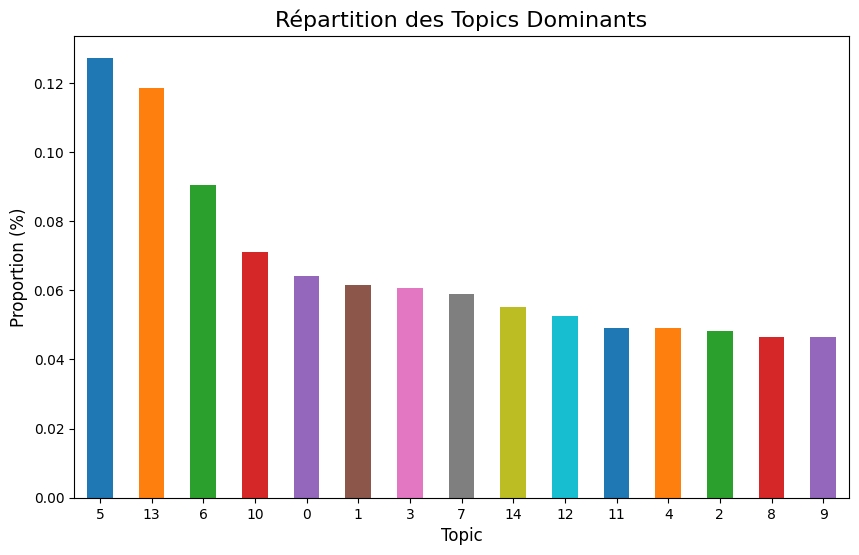

In [18]:
#Fonction permettant d'afficher les mots les plus courant d'un topic en question
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        display(f"Topic {topic_idx+1}: {', '.join(top_words)}")



# Transformer TF-IDF en une Matrice Exploitable par LDA
count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
count_matrix = count_vectorizer.fit_transform(dataPrepared['text'])



# Configuration du modèle LDA pour l'appliquer
n_topics = 15  # Nombre de topics à identifier ( variable à ajuster pour avoir +/- de topic majeur à identifier)



# Préparer les données tokenisées
tokenized_texts = [text.split() for text in dataPrepared['text']]

# Créer un dictionnaire et un corpus
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Entraîner un modèle LDA
lda_model_gensim = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=10, random_state=42)

lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)

# Entraînement du modèle
lda_topics = lda_model.fit_transform(count_matrix)


# Obtenir les mots les plus représentatifs de chaque topic
feature_names = count_vectorizer.get_feature_names_out()


# Associer chaque tweet à son topic dominant
topic_assignments = np.argmax(lda_topics, axis=1)

# Ajouter au DataFrame
dataPrepared['Topic'] = topic_assignments

# Afficher pour chaque répartition son nombre d'itération et son occurence normalisée dans le même tableau
topic_counts = dataPrepared['Topic'].value_counts(normalize=True)

# Convertir les occurrences en pourcentages
topic_counts_percent = dataPrepared['Topic'].value_counts()

# Créer un tableau avec le nombre d'occurrences et les pourcentages
topic_stats = pd.DataFrame({
    'Représentation (%)': topic_counts,
    'Occurence': topic_counts_percent
})

display("Visualisation des recurrences et de la répartition des topics :")

# Afficher le tableau
display(topic_stats)


display("Affichage des topics principaux représenté dans nos tweets :")
# Afficher les topics principaux représenté 1,3,0,2,4
print_top_words(lda_model, feature_names, n_top_words=10)


display("Visualisation de la répartition des topics via un graph normalisé :")
# Visualisation de la répartition des topics via un graph normalisé
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=colors)
plt.title('Répartition des Topics Dominants', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.show()





On observe que nous avons des topics ayant une réparition +/- équivalente, ce qui signifie que ces 7 topics sont à peu près représentés de la même manière dans nos tweets.


Evaluons la cohérence de nos topics


In [19]:
#Evaluons la cohérence de nos topics
coherence_model = CoherenceModel(model=lda_model_gensim, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Score de cohérence des topics : {coherence_score}")

Score de cohérence des topics : 0.44304530554866994


Visualisation du nuage des mots de chaque topics


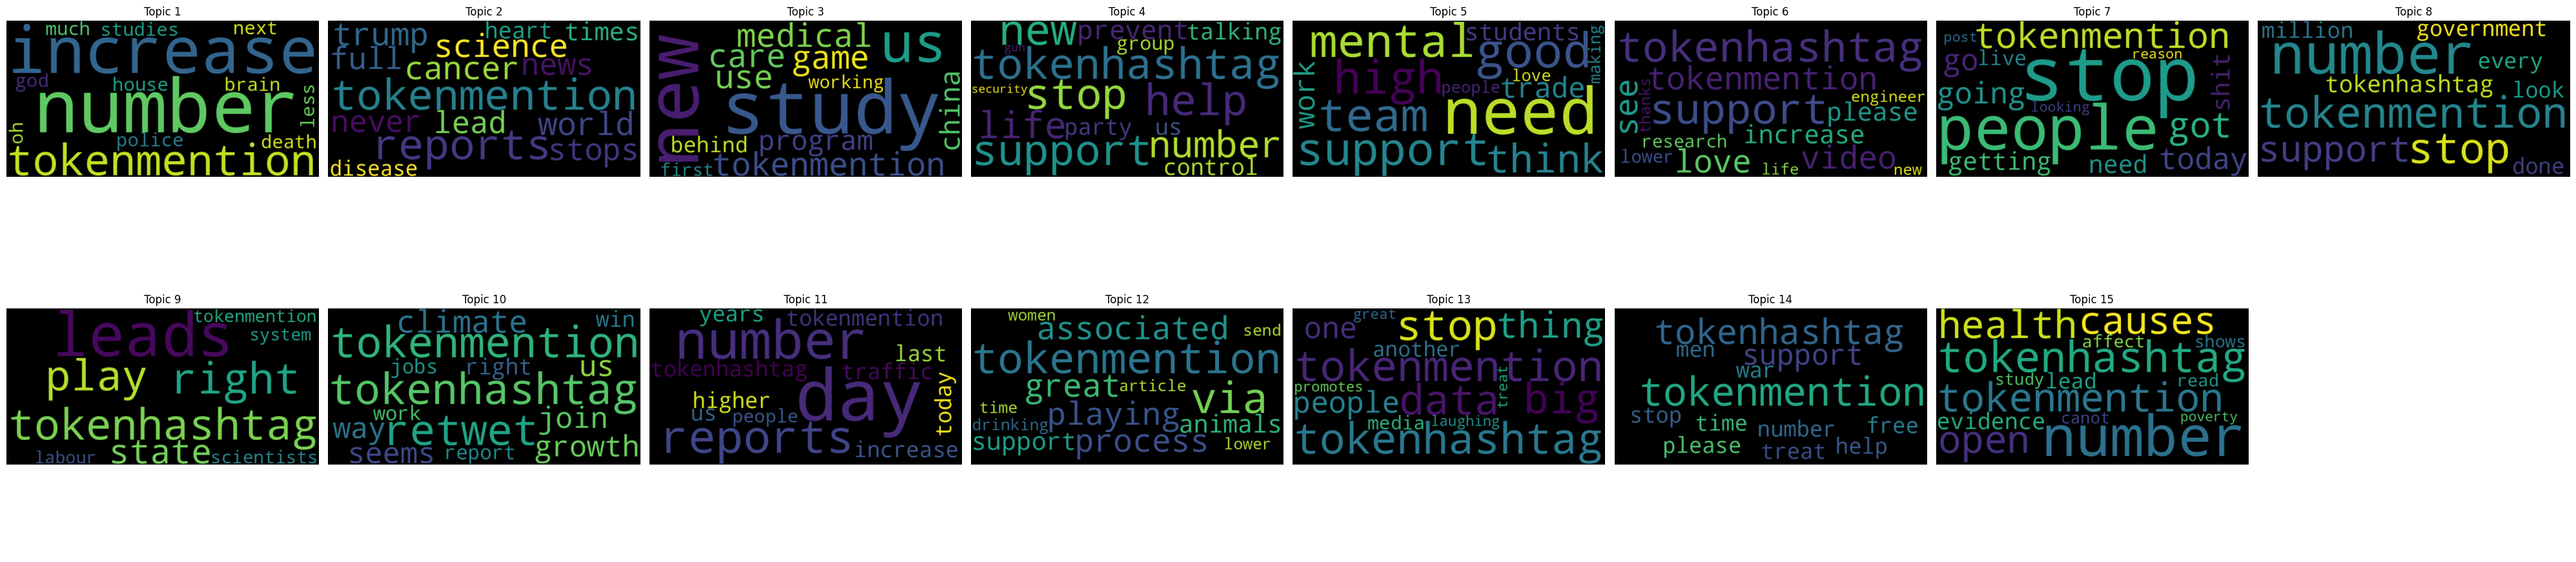

In [20]:
n_topics = len(lda_model.components_)


n_rows = 2
n_cols = (n_topics // n_rows) + (n_topics % n_rows > 0)


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()
# Boucle sur chaque topic pour créer le nuage de mots
for topic_idx, topic in enumerate(lda_model.components_):
    # Générer le nuage de mots pour chaque topic
    wordcloud = WordCloud(width=800, height=400).generate(" ".join([feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]))
    # Afficher le nuage de mots dans le sous-graphe approprié
    axes[topic_idx].imshow(wordcloud, interpolation="bilinear")
    axes[topic_idx].axis("off")  # Retirer les axes
    axes[topic_idx].set_title(f"Topic {topic_idx + 1}")
for i in range(n_topics, len(axes)):
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## **Upsampling**

<br>

Après avoir effectué notre topic modelling afin d'identifier les idées principales de nos tweets, nous allons appliquer un Upsampling.

<br>

Dans le domaine des méthodes d'apprentissage automatique, l'upsampling est utilisé afin d'équilibrer nos classes désséquilibrées en augmentant les classes qui sont sous représentés. De ce fait, nous aurons une meilleure répartion de nos classes (**science_related, scientific_claim, scientific_reference, scientific_context**). Voici un extrait de chaque classe dans notre dataset préparé avant l'upsampling :

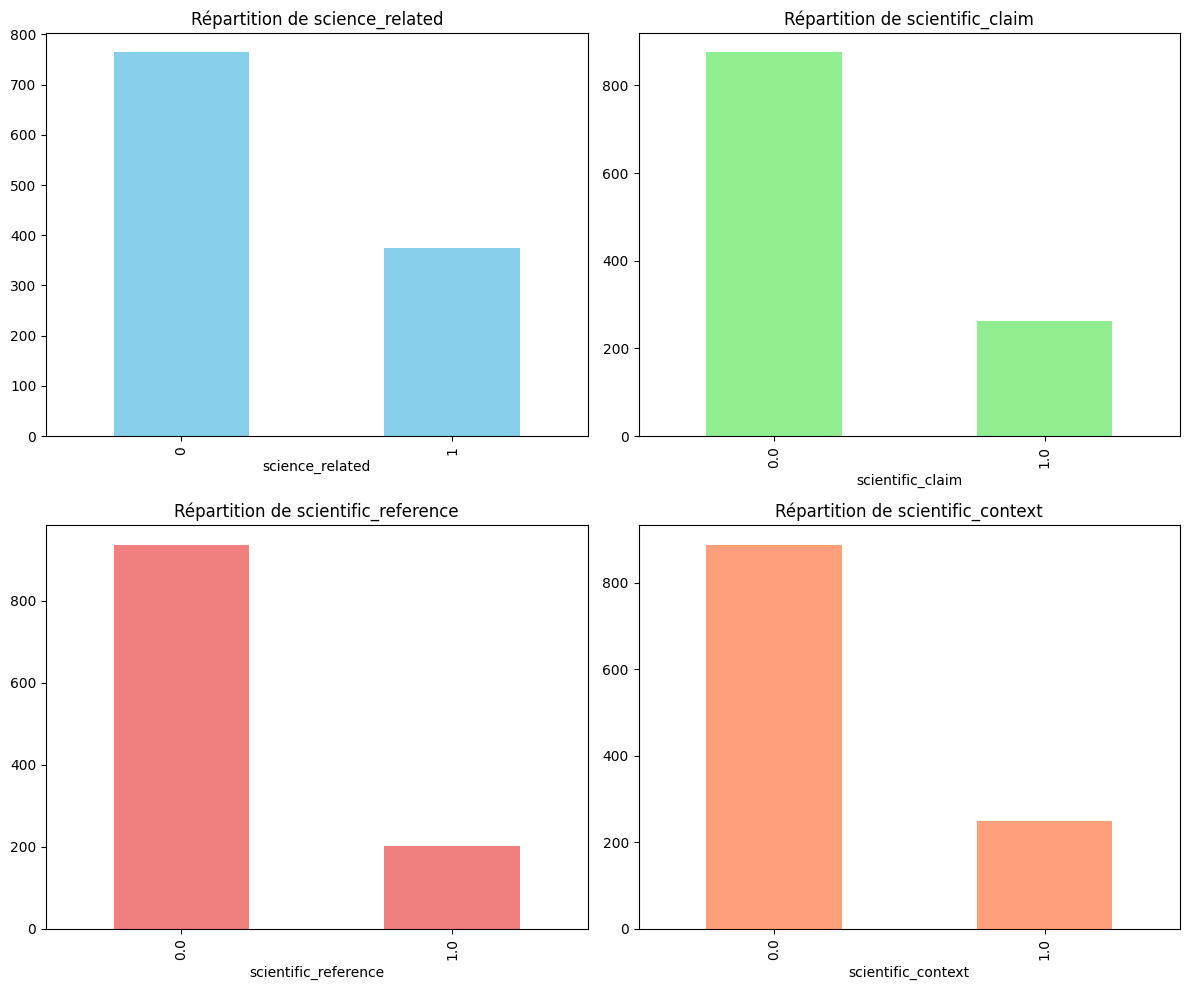

In [21]:
#affichage de chaque classe dans un graph
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 lignes, 2 colonnes pour les sous-graphiques

# Afficher la répartition de chaque colonne dans un sous-graphe
dataPrepared['science_related'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Répartition de science_related')

dataPrepared['scientific_claim'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Répartition de scientific_claim')

dataPrepared['scientific_reference'].value_counts().plot(kind='bar', ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_title('Répartition de scientific_reference')

dataPrepared['scientific_context'].value_counts().plot(kind='bar', ax=axes[1, 1], color='lightsalmon')
axes[1, 1].set_title('Répartition de scientific_context')


plt.tight_layout()
plt.show()
#print la répartition


In [22]:
# Définition de notre fonction d'upsampling, utilisant SMOTE
def resampleData(X, y):
    combined = SMOTETomek(random_state=42)
    X_resampled, y_resampled = combined.fit_resample(X, y)
    return X_resampled, y_resampled

Appliquons l'upsampling :

In [23]:
data_lvl1 = dataPrepared.copy()
y = data_lvl1['science_related']
X_text = data_lvl1['text']

#Vectorisation TF-IDF + Scaling
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)

#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_resampled, y_resampled = resampleData(X_train, y_train)

On visualise bien le fait que l'upsampling a bien rééquilibré nos classes et que désormais nous n'avons plus de classes minoritaires.

Text(0.5, 1.0, 'After Resampling')

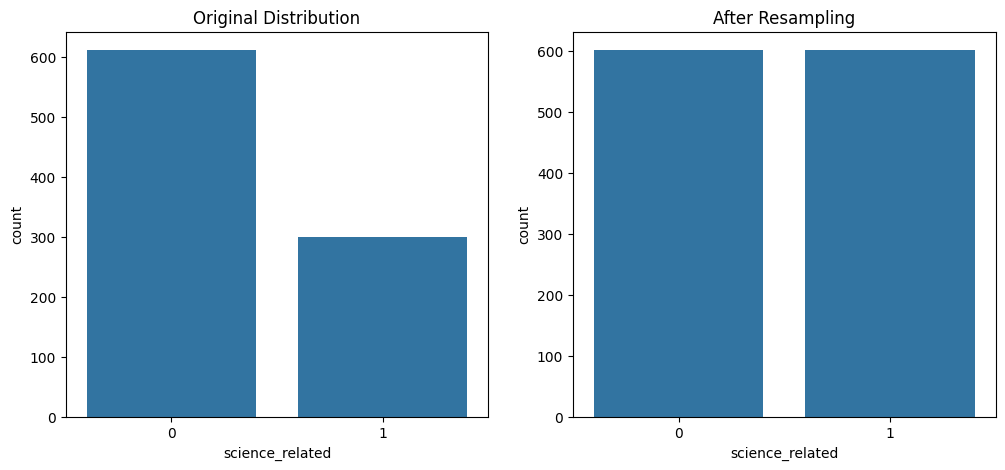

In [24]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title('After Resampling')



# Classification


Le but de la classification est de permettre de déterminer le contexte de nos tweets en fonction de leurs caractéristiques.

<br>

Pour obtenir les meuilleurs résultats possibles, nous allons pour établir 4 méthodes de classification :

<br>


-Decision Tree

-Naïve Bayes

-SVC (Support Vector Clustering)

-KNN (k-nearest neighbors)

<br>


On rappelle nos classes de tweets :

- science_related
- scientific_claim
- scientific_reference
- scientific_context


Puis nous allons les tester sur 3 tâches de classification :

- {SCIENTIFIQUE} vs. {NON SCIENTIFIQUE} (2 classes, pour la classification de niveau 1)
- {CLAIM, REF} vs. {CONTEXT} (deux classes pour la classification de niveau 2)
-{CLAIM} vs. {REF} vs. {CONTEXT} (trois classes pour la classification niveau 3)

<br>

Une fois ce travail réalisé, nous pourrons évaluer les performances de chaque classifieur via plusieurs métriques différentes.


On définis nos fonctions d'affichage de courbes :

In [25]:
#Fonction d'affichage des courbes
def plot_curves_confusion(confusion_matrix, class_names):
    plt.figure(1, figsize=(16, 6))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1, top=0.9, wspace=0.25, hspace=0)

    # Matrice de confusion
    plt.subplot(1, 3, 3)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted', fontsize=12)
    plt.title("Confusion matrix")
    plt.ylabel('True', fontsize=12)
    plt.show()


def plot_curves(scores):
    plt.figure(1, figsize=(16, 6))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1, top=0.9, wspace=0.25, hspace=0)

    # Plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(scores, color='blue')
    plt.ylabel('Loss')
    plt.xlabel('Fold')

    # Plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(1 - scores, color='red')
    plt.ylabel('Error Rate')
    plt.xlabel('Fold')

    plt.show()

def plot_curves_results(naive_scores, svc_scores, decision_scores, knn_scores):
  classifiers = ['Naive Bayes', 'SVC', 'Decision Tree', 'KNN']

  fold_scores = [naive_scores, svc_scores, decision_scores, knn_scores]

  # Scores moyens
  plt.figure(figsize=(8, 5))
  mean_scores = [score.mean() for score in fold_scores]
  plt.bar(classifiers, mean_scores, color=['blue', 'orange', 'green', 'red'])
  plt.title('Scores moyens des classifieurs')
  plt.xlabel('Classifieurs')
  plt.ylabel('Score moyen')
  plt.show()


# **Classification {SCI} vs {NON-SCI} (NIVEAU 1)**

On définit nos données d'entrainement pour la classification de niveau 1 :

In [26]:
#Copie de nos données d'entrées
data_lvl1 = dataPrepared.copy()
y = data_lvl1['science_related']
X_text = data_lvl1['text']

#Vectorisation TF-IDF + Scaling
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)

#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Upsampling du jeu d'entraînement SEULEMENT
print(f"sizes of the classes before resampling : {Counter(y_train)}")

X_resampled, y_resampled = resampleData(X_train, y_train)

print(f"sizes of the classes after resampling : {Counter(y_resampled)}")

sizes of the classes before resampling : Counter({0: 612, 1: 299})
sizes of the classes after resampling : Counter({0: 602, 1: 602})


##**Recherches des paramètres optimaux des classifieurs**

Nous allons utiliser GridSearchCV afin de trouver les paramètres optimaux pour les classifieurs. Nous avons expérimenté avec une petite plage de recherche peu précise au cours du projet afin d'itérer rapidement. Après avoir acquis plus de connaissances, nous avons décidé de pousser la recherche de paramètres ici.

Bien entendu, les résultats sont stockés dans un fichier pour éviter de les recalculer à chaque fois.

In [29]:
def perform_gridsearch_and_plot(X_resampled, y_resampled, X_test, y_test, level, filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            best_params = json.load(f)
        print(f"Loaded best parameters from {filename}")
    else:
        best_params = {}

        # Decision Tree
        param_grid_dt = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 5, 7, 10, 20, 30, 40, 50, None],
            'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
            'min_samples_leaf': [1, 2, 4, 6, 8, 10]
        }

        dt = DecisionTreeClassifier(random_state=42)
        grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
        grid_dt.fit(X_resampled, y_resampled)

        results = grid_dt.cv_results_
        params = results['params']
        scores = results['mean_test_score']

        gini_scores = [s for s, p in zip(scores, params) if p['criterion'] == 'gini']
        entropy_scores = [s for s, p in zip(scores, params) if p['criterion'] == 'entropy']

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(gini_scores)), gini_scores, label='Gini', color='steelblue')
        plt.plot(range(len(entropy_scores)), entropy_scores, label='Entropy', color='seagreen')
        plt.title(f'Decision Tree (Level {level}) - Mean F1 Macro Score Comparison', fontsize=14)
        plt.xlabel('Parameter Combination Index', fontsize=12)
        plt.ylabel('Mean F1 Macro Score', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        best_params["DecisionTree"] = grid_dt.best_params_

        # Naive Bayes
        param_grid_nb = {'alpha': np.logspace(-3, 3, num=100), 'fit_prior': [True, False]}
        nb = MultinomialNB()
        grid_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='f1_macro')
        grid_nb.fit(X_resampled, y_resampled)

        scores_nb_true = grid_nb.cv_results_['mean_test_score'][::2]
        scores_nb_false = grid_nb.cv_results_['mean_test_score'][1::2]
        alphas = param_grid_nb['alpha']

        plt.figure(figsize=(8, 6))
        plt.plot(alphas, scores_nb_true, label='fit_prior=True', color='teal')
        plt.plot(alphas, scores_nb_false, label='fit_prior=False', color='darkorange')
        plt.title(f'Multinomial Naive Bayes (Level {level}) - F1 Score vs Alpha', fontsize=14)
        plt.xlabel('Alpha', fontsize=12)
        plt.xscale('log')
        plt.ylabel('Mean F1 Macro Score', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        best_params["MultinomialNB"] = grid_nb.best_params_

        # KNN
        param_grid_knn = {
            'n_neighbors': list(range(1, 31)),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
          }
        knn = KNeighborsClassifier()
        grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1_macro')
        grid_knn.fit(X_resampled, y_resampled)

        # Organize results by metric and weights
        scores_by_metric = defaultdict(lambda: defaultdict(list))

        for params, score in zip(grid_knn.cv_results_['params'], grid_knn.cv_results_['mean_test_score']):
            metric = params['metric']
            weights = params['weights']
            n_neighbors = params['n_neighbors']
            scores_by_metric[metric][weights].append((n_neighbors, score))

        # Plot for each metric
        fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        metrics = ['euclidean', 'manhattan', 'minkowski']
        colors = ['royalblue', 'darkorange']

        for i, metric in enumerate(metrics):
            ax = axs[i]
            for j, weights in enumerate(['uniform', 'distance']):
                data = sorted(scores_by_metric[metric][weights], key=lambda x: x[0])
                neighbors = [x[0] for x in data]
                scores = [x[1] for x in data]
                ax.plot(neighbors, scores, label=f'weights={weights}', color=colors[j])
            ax.set_title(f'KNN - metric={metric}', fontsize=13)
            ax.set_xlabel('n_neighbors', fontsize=11)
            ax.set_ylabel('Mean F1 Macro Score', fontsize=11)
            ax.legend()
            ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


        best_params["KNN"] = grid_knn.best_params_

        # SVC
        c_values = np.logspace(-3, 3, num=100)
        param_grid_svc = {
            'C': c_values,
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['auto', 'scale']
        }

        svc = SVC(random_state=42)
        grid_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='f1_macro', n_jobs=-1)
        grid_svc.fit(X_resampled, y_resampled)

        results = grid_svc.cv_results_
        params = results['params']
        scores = results['mean_test_score']

        for gamma_value in ['auto', 'scale']:
          plt.figure(figsize=(10, 6))
          for kernel, color in zip(['linear', 'rbf'], ['blue', 'green']): # kernel = poly yielded consistantly very inferior results so we removed it
              kernel_gamma_scores = [
                  s for s, p in zip(scores, params)
                  if p['kernel'] == kernel and p['gamma'] == gamma_value
              ]
              plt.plot(c_values, kernel_gamma_scores, label=f'kernel={kernel}', color=color)
          plt.title(f'SVC (Level {level}) - gamma={gamma_value}', fontsize=14)
          plt.xlabel('C', fontsize=12)
          plt.xscale('log')
          plt.ylabel('Mean F1 Macro Score', fontsize=12)
          plt.legend()
          plt.grid(alpha=0.3)
          plt.tight_layout()
          plt.show()


        best_params["SVC"] = grid_svc.best_params_

        # Save the best parameters to file
        with open(filename, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"Saved best parameters to {filename}")

    # Display all best parameters
    for model_name, params in best_params.items():
        print(f"Best parameters for {model_name} (Level {level}): {params}")

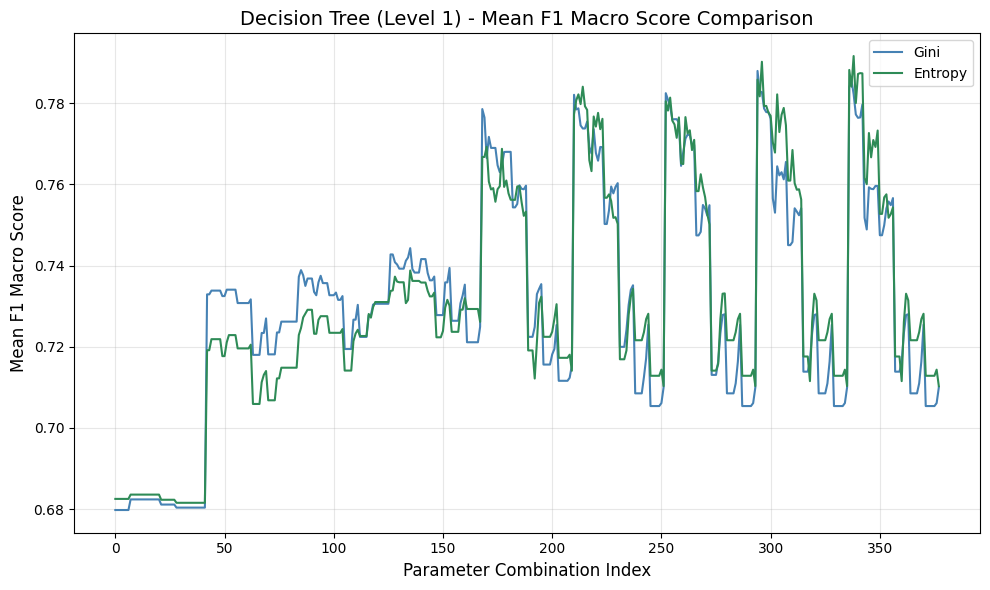

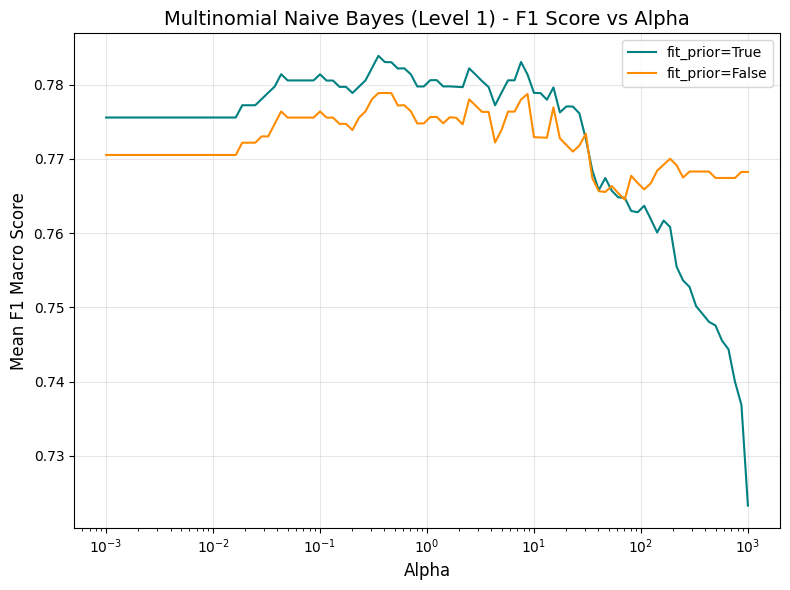

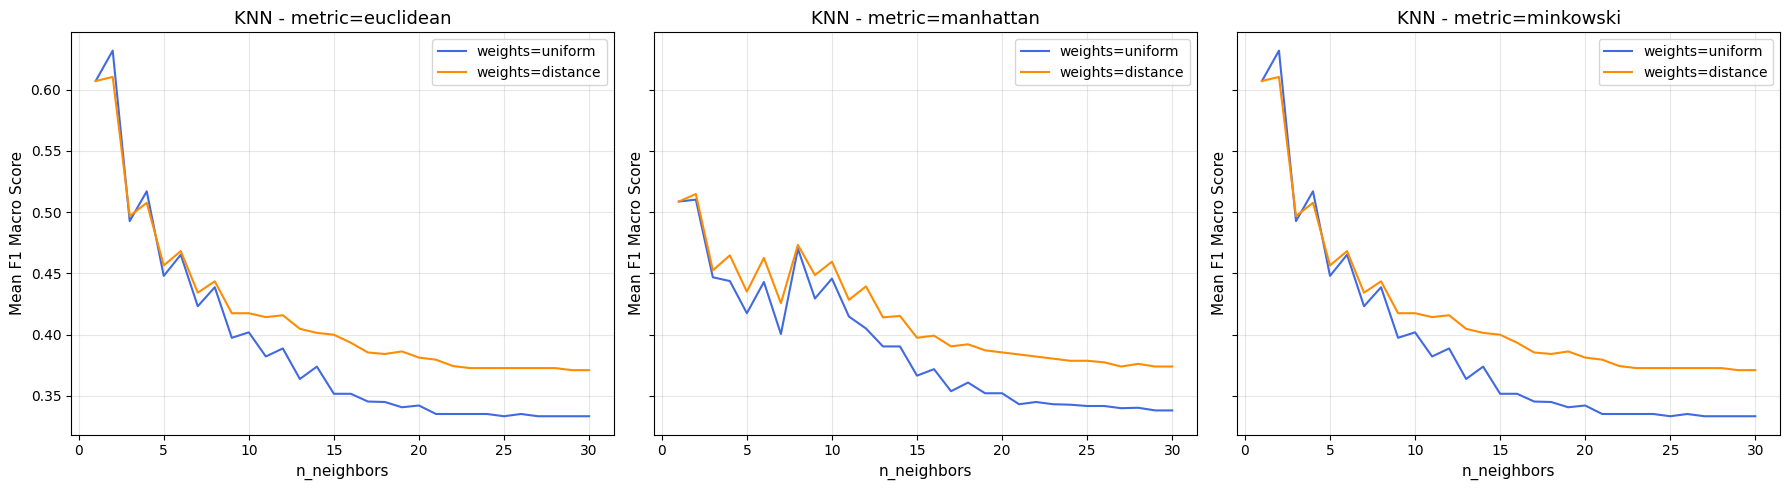

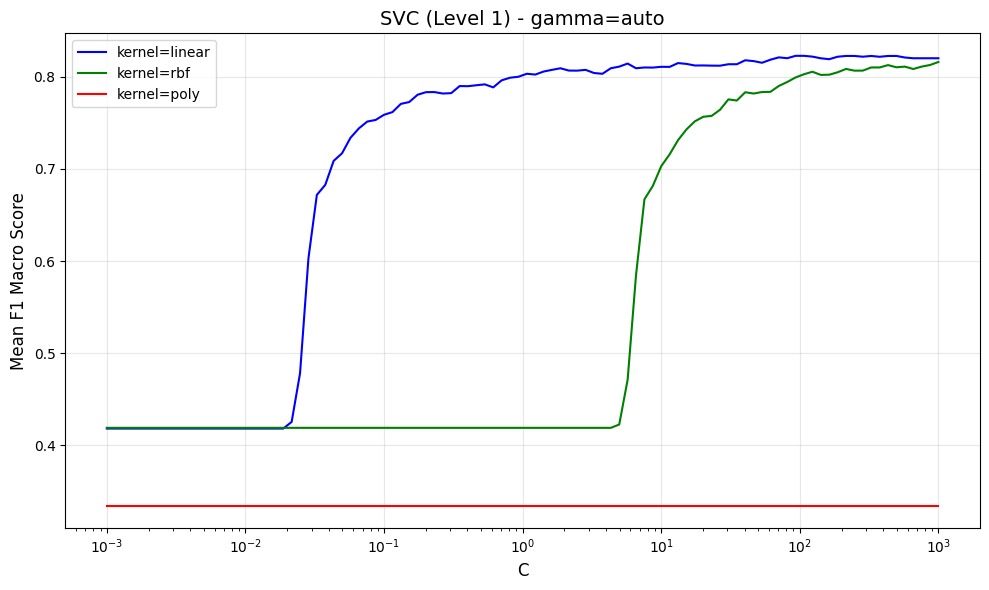

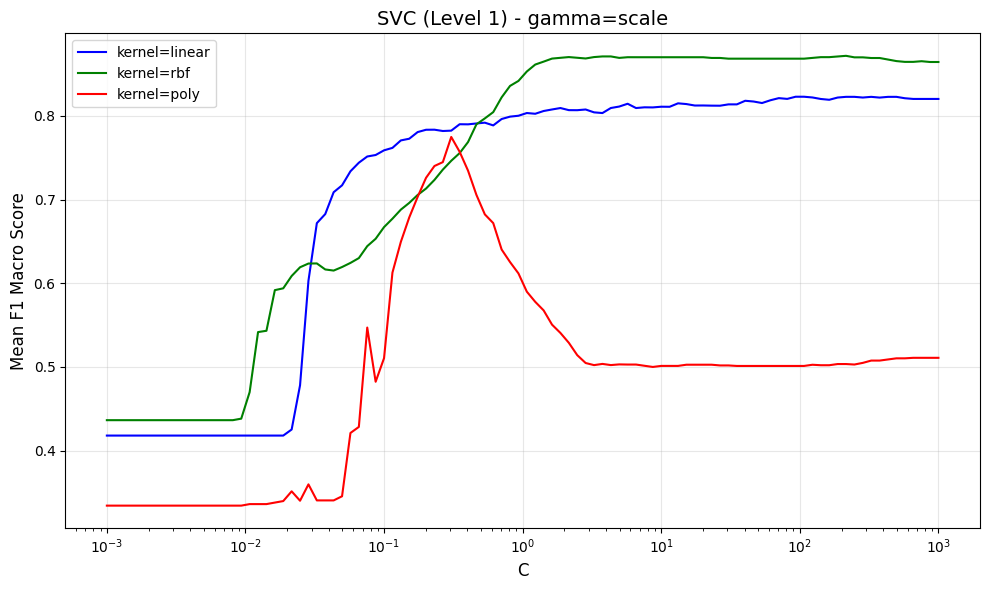

Saved best parameters to dataSet/lvl1_parameters.json
Best parameters for DecisionTree (Level 1): {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best parameters for MultinomialNB (Level 1): {'alpha': 0.3511191734215131, 'fit_prior': True}
Best parameters for KNN (Level 1): {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
Best parameters for SVC (Level 1): {'C': 215.44346900318865, 'gamma': 'scale', 'kernel': 'rbf'}


In [30]:

perform_gridsearch_and_plot(X_resampled, y_resampled, X_test, y_test, 1, "dataSet/lvl1_parameters.json")

In [ ]:
# Définition de la fonction qui permet seulement de charger les paramètres sauvegardés
def load_models_from_file(filename):
    with open(filename, 'r') as f:
        best_params = json.load(f)

    models = {}

    if "DecisionTree" in best_params:
        models["DecisionTree"] = DecisionTreeClassifier(**best_params["DecisionTree"], random_state=42)

    if "MultinomialNB" in best_params:
        models["MultinomialNB"] = MultinomialNB(**best_params["MultinomialNB"])

    if "KNN" in best_params:
        models["KNN"] = KNeighborsClassifier(**best_params["KNN"])

    if "SVC" in best_params:
        models["SVC"] = SVC(**best_params["SVC"], random_state=42)

    return models

lvl1_best_params = load_models_from_file("dataSet/lvl1_parameters.json")

print(lvl1_best_params)

##**Decision Tree**

In [ ]:

best_tree = lvl1_best_params["DecisionTree"]

print("Paramètres :", best_tree.get_params())

best_tree.fit(X_resampled, y_resampled)

# Cross-validation sur données équilibrées
cv_scores = cross_val_score(best_tree, X_resampled, y_resampled, cv=10)
print("Scores CV :", cv_scores)
print("Moyenne CV :", cv_scores.mean())

# Prédiction sur le vrai test (non modifié)
y_pred = best_tree.predict(X_test)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred))
print(" Classification Report (test) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Tes fonctions de visualisation (si elles existent)
plot_curves(cv_scores)
plot_curves_confusion(conf_matrix, ['NON-SCI', 'SCI'])

##**Naive bayes**

In [ ]:

best_naive_bayes_classifier = lvl1_best_params["MultinomialNB"]

print("Paramètres :", best_naive_bayes_classifier.get_params())

best_naive_bayes_classifier.fit(X_resampled, y_resampled)

naive_scores = cross_val_score(best_naive_bayes_classifier, X_resampled, y_resampled, cv=10)
print("Scores CV :", naive_scores)
print("Moyenne CV :", naive_scores.mean())


y_pred_test = best_naive_bayes_classifier.predict(X_test)

# Rapports
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualisation
plot_curves(naive_scores)
plot_curves_confusion(conf_matrix, ['NON-SCI', 'SCI'])


##**SVC**

In [ ]:
best_svc_classifier = lvl1_best_params["SVC"]

print("Paramètres :", best_svc_classifier.get_params())

best_svc_classifier.fit(X_resampled, y_resampled)

svc_scores = cross_val_score(best_svc_classifier, X_resampled, y_resampled, cv=10)
print("Scores de validation croisée :", svc_scores)
print("Moyenne :", svc_scores.mean())

y_pred_cv = cross_val_predict(best_svc_classifier, X_resampled, y_resampled, cv=10)

conf_matrix = confusion_matrix(y_resampled, y_pred_cv)
plot_curves(svc_scores)
plot_curves_confusion(conf_matrix, ['NON-SCI', 'SCI'])


##KNN

In [ ]:
best_knn_classifier = lvl1_best_params["KNN"]

print("Paramètres :", best_knn_classifier.get_params())

best_knn_classifier.fit(X_resampled, y_resampled)

knn_scores = cross_val_score(best_knn_classifier, X_resampled, y_resampled, cv=10)
print("Scores de validation croisée :", knn_scores)
print("Moyenne :", knn_scores.mean())


y_pred_test = best_knn_classifier.predict(X_test_scaled)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Rapport de classification :\n", classification_report(y_test, y_pred_test))


conf_matrix = confusion_matrix(y_test, y_pred_test)


results_df = pd.DataFrame(random_search.cv_results_)
scores_by_k = results_df.groupby('param_n_neighbors')['mean_test_score'].mean()

plt.figure(figsize=(8, 5))
plt.title('Scores KNN en fonction du nombre de voisins')
plt.plot(scores_by_k.index, scores_by_k.values, marker='o')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score de validation croisée')
plt.grid(True)
plt.show()

plot_curves(knn_scores)
plot_curves_confusion(conf_matrix, ['NON-SCI', 'SCI'])


##**Evaluation des classificeurs (Niveau 1)**

In [ ]:
def compute_mean_and_ci(scores):
    mean = scores.mean()
    std = scores.std()
    n = len(scores)
    ci_width = stats.t.ppf(0.975, df=n-1) * (std / np.sqrt(n))  # Half-width (±)
    return mean, ci_width

def print_accuracy_with_pm(name, scores):
    mean, ci_width = compute_mean_and_ci(scores)
    pm_percent = (ci_width / mean) * 100
    print(f"{name} : {mean:.4f} ± {pm_percent:.2f}%")

def plot_curves_results_with_ci(scores_list, names=None, colors=None):
    means = []
    cis = []

    for scores in scores_list:
        mean, ci_width = compute_mean_and_ci(scores)
        means.append(mean)
        cis.append(ci_width)

    if names is None:
        names = [f"Model {i+1}" for i in range(len(scores_list))]

    if colors is None:
        colors = ['royalblue', 'seagreen', 'tomato', 'mediumpurple']

    # Plot
    x = np.arange(len(names))
    plt.figure(figsize=(10,6))
    bars = plt.bar(x, means, yerr=cis, capsize=8, color=colors, edgecolor='black')

    plt.xticks(x, names)
    plt.ylabel('Accuracy')
    plt.title('Score moyen des classifieurs')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)

    plt.show()


# Plot courbes
plot_curves_results_with_ci(
    [naive_scores, svc_scores, cv_scores, knn_scores],
    names=['Naive Bayes', 'SVC', 'Decision Tree', 'KNN']
)

# Print précision ± confiance
print_accuracy_with_pm("Naive Bayes", naive_scores)
print_accuracy_with_pm("SVC", svc_scores)
print_accuracy_with_pm("Decision Tree", cv_scores)
print_accuracy_with_pm("KNN", knn_scores)

# **Classification {CLAIM, REF} vs CONTEXT (Niveau 2)**

On définit nos données d'entraînement pour cette classification de niveau 2 :

In [ ]:
# Copie des données pour le niveau 2
data_lvl2 = dataPrepared.copy()
# Combiner 'scientific_claim' et 'scientific_reference' en une seule colonne
data_lvl2['claim_or_ref'] = data_lvl2.apply(lambda row: 1 if row['scientific_claim'] == 1 or row['scientific_reference'] == 1 else 0, axis=1)
y = data_lvl2['claim_or_ref'] # la colonne cible pour le niveau 2
X_text = data_lvl2['text']

# Vectorisation TF-IDF + Scaling =========
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)

# Split train/test =========
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"sizes of the classes before resampling : {Counter(y_train)}")

X_resampled, y_resampled = resampleData(X_train, y_train)

print(f"sizes of the classes after resampling : {Counter(y_resampled)}")

##**Recherche des paramètres optimaux des classifieurs**


In [ ]:
perform_gridsearch_and_plot(X_resampled, y_resampled, X_test, y_test, 2, "dataSet/lvl2_parameters.json")

In [ ]:
lvl2_best_params = load_models_from_file("dataSet/lvl2_parameters.json")

print(lvl2_best_params)

##Decision Tree

In [ ]:

best_tree = lvl2_best_params["DecisionTree"]


print("Paramètres :", best_tree.get_params())

best_tree.fit(X_resampled, y_resampled)

# Cross-validation
cv_scores = cross_val_score(best_tree, X_resampled, y_resampled, cv=10)
print("Scores CV :", cv_scores)
print("Moyenne CV :", cv_scores.mean())

# Prédiction
y_pred = best_tree.predict(X_test)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)


plot_curves(cv_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM/REF'])


##Naive bayes

In [ ]:


best_naive_bayes_classifier = lvl2_best_params["MultinomialNB"]

print("Paramètres :", best_naive_bayes_classifier.get_params())

best_naive_bayes_classifier.fit(X_resampled, y_resampled)

naive_scores = cross_val_score(best_naive_bayes_classifier, X_resampled, y_resampled, cv=10)
print("Scores CV :", naive_scores)
print("Moyenne CV :", naive_scores.mean())


y_pred_test = best_naive_bayes_classifier.predict(X_test)


print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred_test))


conf_matrix = confusion_matrix(y_test, y_pred_test)

plot_curves(naive_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM/REF']) # Updated labels for level 2


##SVC

In [ ]:
# --- Step 1: RESAMPLE THE TRAINING DATA TO BALANCE CLASSES ---

# Optional: use imblearn if your resampleData() doesn't work well
# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert to dense format if sparse
X_resampled_dense = X_resampled.toarray() if hasattr(X_resampled, "toarray") else X_resampled
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# --- Step 2: SCALE BOTH TRAIN AND TEST DATA USING SAME SCALER ---
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled_dense)  # fit on train
X_test_scaled = scaler.transform(X_test_dense)  # transform test with same scaler

# --- Step 3: HYPERPARAMETER SEARCH FOR SVC ---




# --- Step 4: VALIDATE WITH CROSS-VAL ON TRAIN ---

best_svc_classifier = lvl2_best_params["SVC"]

print("Best SVC params:", random_search.best_params_)

best_svc_classifier.fit(X_resampled_scaled, y_resampled)


svc_scores = cross_val_score(best_svc_classifier, X_resampled_scaled, y_resampled, cv=10)
print("Cross-val scores:", svc_scores)
print("Mean:", svc_scores.mean())

# --- Step 5: EVALUATE ON TEST SET ---

y_pred_test = best_svc_classifier.predict(X_test_scaled)

print("\nAccuracy (test):", accuracy_score(y_test, y_pred_test))
print("Classification Report (test):")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
plot_curves(svc_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM/REF'])


##KNN

In [ ]:
best_knn_classifier = lvl2_best_params["KNN"]

print("Paramètres :", best_knn_classifier.get_params())

best_knn_classifier.fit(X_resampled, y_resampled)

knn_scores = cross_val_score(best_knn_classifier, X_resampled, y_resampled, cv=10)
print("Scores de validation croisée :", knn_scores)
print("Moyenne :", knn_scores.mean())


y_pred_test = best_knn_classifier.predict(X_test_scaled)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Rapport de classification :\n", classification_report(y_test, y_pred_test))


conf_matrix = confusion_matrix(y_test, y_pred_test)

scores_by_k = results_df.groupby('param_n_neighbors')['mean_test_score'].mean()

plt.figure(figsize=(8, 5))
plt.title('Scores KNN en fonction du nombre de voisins')
plt.plot(scores_by_k.index, scores_by_k.values, marker='o')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score de validation croisée')
plt.grid(True)
plt.show()


plot_curves(knn_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM/REF'])


## **Evaluation des classifieurs (niveau 2)**

In [ ]:
#Evaluation des classifieurs

# Plot courbes
plot_curves_results_with_ci(
    [naive_scores, svc_scores, cv_scores, knn_scores],
    names=['Naive Bayes', 'SVC', 'Decision Tree', 'KNN']
)

# Print précision ± confiance
print_accuracy_with_pm("Naive Bayes", naive_scores)
print_accuracy_with_pm("SVC", svc_scores)
print_accuracy_with_pm("Decision Tree", cv_scores)
print_accuracy_with_pm("KNN", knn_scores)

# **Classification {CLAIM} VS {REF} VS {CONTEXT} (niveau 3)**

On définit nos données d'entraînement pour cette classification de niveau 3 :

In [ ]:
data_lvl3 = dataPrepared.copy()


def get_level3_label(row):
    if row['scientific_claim'] == 1:
        return 'CLAIM'
    elif row['scientific_reference'] == 1:
        return 'REF'
    elif row['scientific_context'] == 1:
        return 'CONTEXT'
    else:
        return 'NON-SCI'

def apply_level3_label(data):
    data['level3_label'] = data.apply(get_level3_label, axis=1)
    # drop all non sci
    data = data[data['level3_label'] != 'NON-SCI']
    return data

data_lvl3 = apply_level3_label(data_lvl3)
y = data_lvl3['level3_label']
X_text = data_lvl3['text']

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"sizes of the classes before resampling : {Counter(y_train)}")

X_resampled, y_resampled = resampleData(X_train, y_train)

print(f"sizes of the classes after resampling : {Counter(y_resampled)}")

##**Recherche des paramètres optimaux des classifieurs**

In [ ]:
perform_gridsearch_and_plot(X_resampled, y_resampled, X_test, y_test, 3, "dataSet/lvl3_parameters.json")

In [ ]:
lvl3_best_params = load_models_from_file("dataSet/lvl3_parameters.json")

print(lvl3_best_params)

## **Decision tree**

In [ ]:
best_tree = lvl3_best_params["DecisionTree"]

print("Paramètres :", best_tree.get_params())

best_tree.fit(X_resampled, y_resampled)

# Cross-validation
cv_scores = cross_val_score(best_tree, X_resampled, y_resampled, cv=10)
print("Scores CV :", cv_scores)
print("Moyenne CV :", cv_scores.mean())

# Prediction
y_pred = best_tree.predict(X_test)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plot_curves(cv_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM', 'REF'])


## **Naive bayes**

In [ ]:
best_naive_bayes_classifier = lvl3_best_params["MultinomialNB"]

print("Paramètres :", best_naive_bayes_classifier.get_params())

best_naive_bayes_classifier.fit(X_resampled, y_resampled)

naive_scores = cross_val_score(best_naive_bayes_classifier, X_resampled, y_resampled, cv=10)
print("Scores CV :", naive_scores)
print("Moyenne CV :", naive_scores.mean())

y_pred_test = best_naive_bayes_classifier.predict(X_test)

print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

plot_curves(naive_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM', 'REF'])


## **SVC**

In [ ]:
# ##SVC

X_resampled, y_resampled = resampleData(X_train, y_train)
print("Resampled class distribution:", Counter(y_resampled))

X_resampled_dense = X_resampled.toarray() if hasattr(X_resampled, "toarray") else X_resampled
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled_dense)
X_test_scaled = scaler.transform(X_test_dense)
clf_SVC = SVC()



best_svc_classifier = lvl3_best_params["SVC"]

print("Paramètres :", best_svc_classifier.get_params())

best_svc_classifier.fit(X_resampled_scaled, y_resampled)

svc_scores = cross_val_score(best_svc_classifier, X_resampled_scaled, y_resampled, cv=10)
print("Cross-val scores:", svc_scores)
print("Mean:", svc_scores.mean())

# --- Step 5: EVALUATE ON TEST SET ---

y_pred_test = best_svc_classifier.predict(X_test_scaled)

print("\nAccuracy (test):", accuracy_score(y_test, y_pred_test))
print("Classification Report (test):")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
plot_curves(svc_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM', 'REF'])

## **KNN**

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Assuming X_train, X_test, y_train, y_test from previous level 3 setup
X_resampled, y_resampled = resampleData(X_train, y_train)  # use yours
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())
X_test_scaled = scaler.transform(X_test.toarray())



best_knn_classifier = lvl3_best_params["KNN"]

print("Paramètres :", best_knn_classifier.get_params())

best_knn_classifier.fit(X_resampled, y_resampled)

knn_scores = cross_val_score(best_knn_classifier, X_resampled, y_resampled, cv=10)
print("Scores de validation croisée :", knn_scores)
print("Moyenne :", knn_scores.mean())

y_pred_test = best_knn_classifier.predict(X_test)
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Rapport de classification :\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)


scores_by_k = results_df.groupby('param_n_neighbors')['mean_test_score'].mean()

plot_curves(knn_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM', 'REF'])



## **Evaluation des classifieurs (Niveau 3)**

In [ ]:
# Evaluation des classifieurs

# Plot courbes
plot_curves_results_with_ci(
    [naive_scores, svc_scores, cv_scores, knn_scores],
    names=['Naive Bayes', 'SVC', 'Decision Tree', 'KNN']
)

# Print précision ± confiance
print_accuracy_with_pm("Naive Bayes", naive_scores)
print_accuracy_with_pm("SVC", svc_scores)
print_accuracy_with_pm("Decision Tree", cv_scores)
print_accuracy_with_pm("KNN", knn_scores)

# **Optimisation #1 : Utiliser un dataSet plus adapté en faisant varier prepareText**

Actuellement, quand nous avions lancé notre fonction prepareText, nous avions appliqué tous les paramètres possibles. Cependant, il est possible que nous obtenions un dataSet de meilleure qualité suivant les paramètres appliqués. Pour cela, nous allons faire tourner notre fonction de préparation de données avec chaque combinaison de paramètre (2⁴ possibilités) et par la suite, nous utiliserons des outils statistiques afin de déterminer quel est le meilleur dataSet à utiliser.

Comme précédement, on va stocker les prétraitements sous forme de fichier afin de gagner du temps lors des réexécutions.

In [ ]:
# Define preprocessing parameter combinations
combinations = {
    "0000": {"keepTokens": False, "keepEmojis": False, "numbersAsTokens": False, "translate": False},
    "0001": {"keepTokens": False, "keepEmojis": False, "numbersAsTokens": False, "translate": True},
    "0010": {"keepTokens": False, "keepEmojis": True, "numbersAsTokens": False, "translate": False},
    "0011": {"keepTokens": False, "keepEmojis": True, "numbersAsTokens": False, "translate": True},
    "0100": {"keepTokens": False, "keepEmojis": False, "numbersAsTokens": True, "translate": False},
    "0101": {"keepTokens": False, "keepEmojis": False, "numbersAsTokens": True, "translate": True},
    "0110": {"keepTokens": False, "keepEmojis": True, "numbersAsTokens": True, "translate": False},
    "0111": {"keepTokens": False, "keepEmojis": True, "numbersAsTokens": True, "translate": True},
    "1000": {"keepTokens": True, "keepEmojis": False, "numbersAsTokens": False, "translate": False},
    "1001": {"keepTokens": True, "keepEmojis": False, "numbersAsTokens": False, "translate": True},
    "1010": {"keepTokens": True, "keepEmojis": True, "numbersAsTokens": False, "translate": False},
    "1011": {"keepTokens": True, "keepEmojis": True, "numbersAsTokens": False, "translate": True},
    "1100": {"keepTokens": True, "keepEmojis": False, "numbersAsTokens": True, "translate": False},
    "1101": {"keepTokens": True, "keepEmojis": False, "numbersAsTokens": True, "translate": True},
    "1110": {"keepTokens": True, "keepEmojis": True, "numbersAsTokens": True, "translate": False},
    "1111": {"keepTokens": True, "keepEmojis": True, "numbersAsTokens": True, "translate": True}
}

# Ensure dataset folder exists
os.makedirs("dataSet", exist_ok=True)

# Dictionary to store all dataframes
dataPrepared = {}

# Process all datasets
for key, params in combinations.items():
    file_path = f"dataSet/precomputed/dataPrepared{key}.csv"

    if os.path.exists(file_path):
        print(f"Loading existing dataset: {file_path}")
        dataPrepared[key] = pd.read_csv(file_path)  # Store in dictionary
    else:
        print(f"Processing and saving: {file_path}")
        dataPrepared[key] = df.copy()
        dataPrepared[key]["text"] = dataPrepared[key]["text"].apply(lambda x: prepareText(x, **params))
        dataPrepared[key].to_csv(file_path, index=False)

print("\nAll 16 datasets are ready and stored in `dataPrepared` dictionary!")

On applique la vectorisation sur chaque dataSet :

In [ ]:
for key, dataset in dataPrepared.items():
    print(f"Dataset: {key}")
    file_path = f'dataSet/vectorized_{key}.csv'
    if os.path.exists(file_path):
        print(f"Le fichier {file_path} existe déjà, skipping vectorization for this dataset.")
        continue
    # Nettoyage du dataset courant
    dataset = dataset[dataset['text'] != '']
    dataset = dataset.dropna(subset=['text'])
    dataset['text'] = dataset['text'].fillna('').astype(str)
    dataset['text'] = dataset['text'].apply(lemmatize_taggenize_sentence)
    # Traitement avec gestion d'erreur
    processed_text = []
    for index, text in dataset['text'].items():
        if pd.notnull(text) and text.strip() != "":
            try:
                processed_text.append(process_text_column(text))
            except Exception as e:
                print(f"Erreur à l'index {index} avec le texte : {text}")
                print(f"Exception : {e}")
                processed_text.append("")
        else:
            processed_text.append("")
    dataset['text'] = processed_text  # Remplace directement
    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
    vectorized = vectorizer.fit_transform(dataset['text'])
    # Scaling
    scaled = MaxAbsScaler().fit_transform(vectorized)
    # Conversion + sauvegarde
    vectorized_df = pd.DataFrame(scaled.toarray(), columns=vectorizer.get_feature_names_out())
    vectorized_df.to_csv(file_path, index=False)
    print(f"Vectorized dataset {key} saved.")
    display(vectorized_df.head())
    print("\n" + "-"*50 + "\n")

On va applique notre Topic Modelling sur chaque dataSet :

In [ ]:
def apply_lda_and_save(data, key, n_topics=15):
    file_path_lda = f"dataSet/lda_results_{key}.csv"

    if os.path.exists(file_path_lda):
        print(f"LDA results already exist for dataset {key}. Skipping LDA.")
        return pd.read_csv(file_path_lda)

    print(f"Applying LDA to dataset {key}...")

    count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
    count_matrix = count_vectorizer.fit_transform(data['text'])

    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
    lda_topics = lda_model.fit_transform(count_matrix)
    topic_assignments = np.argmax(lda_topics, axis=1)
    data['Topic'] = topic_assignments

    data.to_csv(file_path_lda, index=False)
    print(f"LDA results for dataset {key} saved.")
    return data


for key in dataPrepared:
    dataPrepared[key] = apply_lda_and_save(dataPrepared[key], key)


On a maintenant tous les dataSet vectorisés, on va chercher quel est le dataSet optimal. Pour cela, on va évaluer la cohérence de chaque dataSet :

In [ ]:
def compute_topic_coherence(texts, n_topics=15):
    stop_words = set(stopwords.words('english'))
    tokenized_texts = [[word for word in doc.lower().split() if word not in stop_words]
                       for doc in texts]

    # Create Dictionary and Corpus
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Gensim LDA model (not scikit-learn)
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=n_topics,
                         random_state=42,
                         passes=10)

    # Compute coherence
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score
coherence_scores = {}

max_score=0
max_key=""
for key in dataPrepared:
    df = dataPrepared[key]
    coherence = compute_topic_coherence(df['text'].tolist(), n_topics=15)
    coherence_scores[key] = coherence
    print(f"Dataset '{key}' → Coherence Score: {coherence:.4f}")
    if(coherence>max_score):
        max_score=coherence
        max_key=key


print(f"The best option is {max_key} with score {max_score}")


On va utiliser alors pour chaque niveau les classifieurs qui on eu le meilleur score.

# Optimisation \#2 : on va utiliser Optuna, un outil de recherche d'hyperparamètres plus performant

En plus du dataSet optimisé, on va non pas utiliser SearchGridCV mais optuna qui est à priori plus efficace pour essyer d'obtenir une meilleur accuracy.

<br>

Pour chaque niveau de classification, on va appliquer nos 2 optimisations pour le meilleur classifieur obtenu précédement (ne montrant aucun signe de surapprentissage).

### Niveau 1

<br>

On utilise notre dataset et Optuna avec le classifieur : Decision Tree



In [ ]:
# -- Copie de tes données
data_lvl1 = dataPrepared["0111"]
y = data_lvl1['science_related']
X_text = data_lvl1['text']

# -- Vectorisation TF-IDF + Scaling
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler_tfidf = MaxAbsScaler()
X_scaled = scaler_tfidf.fit_transform(X_vectorized)

# -- Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# -- Standard Scaling pour le modèle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())
X_test_scaled = scaler.transform(X_test.toarray())

# -- Upsampling pour équilibrer
X_df = pd.DataFrame(X_train_scaled)
X_df['label'] = y_train.values

df_majority = X_df[X_df['label'] == 0]
df_minority = X_df[X_df['label'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train_balanced = df_upsampled.drop('label', axis=1).values
y_train_balanced = df_upsampled['label'].values

# -- Optuna : optimisation du Decision Tree
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    decision_tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    scores = cross_val_score(decision_tree, X_train_balanced, y_train_balanced, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# -- Création et lancement de l'étude
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# -- Meilleurs hyperparamètres
print("Meilleurs hyperparamètres Decision Tree via Optuna :", study.best_params)

# -- Réentraîner avec le meilleur modèle
best_decision_tree_classifier = DecisionTreeClassifier(**study.best_params)
best_decision_tree_classifier.fit(X_train_balanced, y_train_balanced)

# -- Validation croisée
dt_scores = cross_val_score(best_decision_tree_classifier, X_train_balanced, y_train_balanced, cv=10)
print("Scores CV :", dt_scores)
print("Moyenne CV :", dt_scores.mean())

# -- Évaluation sur le test
y_pred_test = best_decision_tree_classifier.predict(X_test_scaled)

print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Rapport de classification :\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

# -- Tes plots
plot_curves(dt_scores)
plot_curves_confusion(conf_matrix, ['NON-SCI', 'SCI'])


0.8350 après

###Niveau 2

<br>  Pour le niveeau 2, c'était Naive Bayes le plus pertinent :

In [ ]:
# 1. Copie des données niveau 2 (sur 0111)
data_lvl2 = dataPrepared["0111"].copy()

# 2. Création de la colonne cible (claim or reference)
data_lvl2['claim_or_ref'] = data_lvl2.apply(lambda row: 1 if row['scientific_claim'] == 1 or row['scientific_reference'] == 1 else 0, axis=1)
y = data_lvl2['claim_or_ref']
X_text = data_lvl2['text']

# 3. Vectorisation TF-IDF + MaxAbsScaler
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)

# 4. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 5. Upsampling
X_df = pd.DataFrame(X_train.toarray())  # Utilisation de .toarray() car Naive Bayes ne supporte pas de sparse matrices
X_df['label'] = y_train.values

df_majority = X_df[X_df['label'] == 0]
df_minority = X_df[X_df['label'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train_balanced = df_upsampled.drop('label', axis=1).values
y_train_balanced = df_upsampled['label'].values

# 6. Optuna pour Naive Bayes
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e1)  # paramètre de lissage
    nb = MultinomialNB(alpha=alpha)
    scores = cross_val_score(nb, X_train_balanced, y_train_balanced, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Meilleurs paramètres trouvés :", study.best_params)

# 7. Entraînement du meilleur modèle
best_nb = MultinomialNB(alpha=study.best_params['alpha'])
best_nb.fit(X_train_balanced, y_train_balanced)

# 8. Validation croisée
nb_scores = cross_val_score(best_nb, X_train_balanced, y_train_balanced, cv=10)
print("Scores de validation croisée :", nb_scores)
print("Moyenne :", nb_scores.mean())

# 9. Test
y_pred_test = best_nb.predict(X_test.toarray())  # Utilisation de .toarray() pour les tests car Naive Bayes ne prend pas de sparse matrix
print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Rapport de classification :\n", classification_report(y_test, y_pred_test))

# 10. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# 11. Courbes
plot_curves(nb_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM/REF'])


On passe d'une accuracy de 0.8918614665354332 à 0.9145792322834646 (soit une augmentation de 2%).

### Niveau 3

Pour notre niveau 3, c'était Naive Bayes le plus performant :

In [ ]:
data_lvl3 = dataPrepared["0111"].copy()

def get_level3_label(row):
    if row['scientific_claim'] == 1:
        return 'CLAIM'
    elif row['scientific_reference'] == 1:
        return 'REF'
    else:
        return 'CONTEXT'

data_lvl3['level3_label'] = data_lvl3.apply(get_level3_label, axis=1)
y = data_lvl3['level3_label']
X_text = data_lvl3['text']

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
X_vectorized = vectorizer.fit_transform(X_text)

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_vectorized)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

naive_bayes_classifier = MultinomialNB()

param_distributions = {
    'alpha': np.logspace(-3, 1, 100)
}

random_search = RandomizedSearchCV(
    estimator=naive_bayes_classifier,
    param_distributions=param_distributions,
    n_iter=20,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit on upsampled training data
random_search.fit(X_train, y_train)

best_naive_bayes_classifier = random_search.best_estimator_

print("✅ Meilleur alpha :", random_search.best_params_['alpha'])

naive_scores = cross_val_score(best_naive_bayes_classifier, X_train, y_train, cv=10)
print("Scores CV :", naive_scores)
print("Moyenne CV :", naive_scores.mean())

y_pred_test = best_naive_bayes_classifier.predict(X_test)

print("\n Accuracy (test) :", accuracy_score(y_test, y_pred_test))
print("Classification Report (test) :")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

plot_curves(naive_scores)
plot_curves_confusion(conf_matrix, ['CONTEXT', 'CLAIM', 'REF'])


On passe cette fois de 0.7848542761586239 à 0.7749761108456761. Nous n'avons pas d'augmentation drastique.